In [1]:
import pandas as pd
import scipy as sp
import matplotlib
import matplotlib.colors as mcolors
import pickle 
from collections import Counter
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, to_tree, dendrogram, linkage
import math
from scipy.spatial.distance import squareform\

import numpy as np
import networkx as nx
from graspologic.match import graph_match
# from sklearn import datasets, manifold
from matplotlib.pyplot import cm
import seaborn as sns
# from adjustText import adjust_text
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pathlib import Path


/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/graspologic/layouts/colors.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
from module.wegog_utils import get_ego_top_NM, prepare_nhood_graphs, perform_matching, matching_distance, df_to_graph
# from module.dendrogram_utils import dendrogram_clustering
from module.gramchd.gmd import sort_adjacencies, distance_stats, perform_matching_distance
# from module.gramchd.nhood import get_io_top_NM
# from src.nhood_vis import df_to_graph
# from module.gramchd.nhood_vis import invert_indices, plot_two_graphs_overlay, plot_two_graphs_from_output
from module.utils import get_mapping_df

In [ ]:
datadate = '20231124'
# nb_name = '992_stability_figures'
nb_name = '09_gm_stability'
cwd = Path.cwd()
save_things=False
if save_things:
    fig_dir = cwd.parent / 'figures' / nb_name
    fig_dir.mkdir(parents=True, exist_ok=True)


In [4]:
vnc_edges = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_edges_{datadate}.csv', index_col=0)

vnc_edges = vnc_edges.groupby(['bodyId_pre', 'bodyId_post'], as_index=False).weight.sum()
vnc_edges.rename(columns={'bodyId_pre':'pre', 'bodyId_post':'post'}, inplace=True)
vnc_meta = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_meta_{datadate}.csv', index_col=0)
vnc_edges.loc[:,'attr'] = vnc_edges.weight.apply(lambda x: {'weight':x})


vnc_meta.bodyId = vnc_meta.bodyId.astype('str')

vnc_edges.pre = vnc_edges.pre.astype('str')
vnc_edges.post = vnc_edges.post.astype('str')

heminames = ['07B', '11A', '11B', '02A', '18B', '12A', '01A', '10B', '06A', \
             '06B', '19A', '21A', '03B', '23B', '12B', '13B', '05B', '20A.22A', \
             '08A', '09A']

n_ids = list(set(vnc_meta[(vnc_meta['hemilineage'].isin(heminames))].bodyId.values)) # the integers have the numpy.int64 datatype!
n_ids = sorted(n_ids)

# nhood matching statistics:

from 14_full_vnc_gmd_slice.ipynb


In [5]:
nhood_ntype_match_df  = pd.read_parquet(f'../../data/vnc/{datadate}_data/14_full_vnc_gmd_slice/func_hemi_hi_ntype_overlap_stats.parquet')


In [6]:

nhood_ntype_match_df.id_1 = nhood_ntype_match_df.id_1.astype(str)
nhood_ntype_match_df.id_2 = nhood_ntype_match_df.id_2.astype(str)

cols = ['bodyId','class', 'hemilineage']
nhood_ntype_match_meta_df = nhood_ntype_match_df.set_index('id_1').join(vnc_meta[cols].set_index('bodyId').add_suffix('_id_1')).reset_index().set_index('id_2').join(vnc_meta[cols].set_index('bodyId').add_suffix('_id_2')).reset_index()

nhood_ntype_match_meta_df['class_match'] = nhood_ntype_match_meta_df['class_id_1'] == nhood_ntype_match_meta_df['class_id_2']
nhood_ntype_match_meta_df['hemilineage_match'] = nhood_ntype_match_meta_df['hemilineage_id_1'] == nhood_ntype_match_meta_df['hemilineage_id_2']

In [7]:
# the worst and best matches 
# best_and_worst = nhood_ntype_match_df.sort_values('numeric_match_score').iloc[[-2, 0]][['id_1', 'id_2']].to_numpy()

best_and_worst = nhood_ntype_match_df.sort_values('numeric_match_score').iloc[[-2, 0]]

In [8]:
# ego matches, and a random sample from the range of matches:
# sample = nhood_ntype_match_df.sort_values('numeric_match_score').query('ego_match==True').sample(random_state=1)[['id_1', 'id_2']].to_numpy()[0]
sample = nhood_ntype_match_df.sort_values('numeric_match_score').query('ego_match==True').sample(random_state=1)

In [9]:
# ego doesn't match, but the highest match score in the neighbourhood:
highest_nonego = nhood_ntype_match_df.sort_values('numeric_match_score').query('ego_match==False').iloc[[-1]]

In [10]:
to_analyse = pd.concat((best_and_worst, sample, highest_nonego)).reset_index(drop=True)

In [11]:
to_analyse

,id_2,id_1,fnorm,graph_edit_distance,euclidean_distance,isexact,ntype_overlap,numeric_match_score,nhood_ntype_match_score,type_id_1,instance_id_1,type_id_2,instance_id_2,ego_match
0,17188,10691,1030.783682,17833,1030.783682,False,46,1.000000,46/46,IN08A002,IN08A002_T2_L,IN08A002,IN08A002_T2_R,True
1,32539,154460,1281.323144,13831,1281.323144,False,26,0.000000,0/26,IN09A096,IN09A096_T1_R,IN09A096,IN09A096_T1_L,True
2,27904,13751,460.473669,6502,460.473669,False,26,0.384615,10/26,IN09A014,IN09A014_T2_R,IN09A014,IN09A014_T1_R,True
3,17580,15649,1213.774691,21295,1213.774691,False,27,0.962963,26/27,IN13B024,IN13B024_T2_L,IN13B028,IN13B028_T1_R,False


In [12]:
# plot_order = [best_and_worst[0], highest_nonego, sample, best_and_worst[1]]

# Stability analysis

In [13]:
# def get_matching_full_inds(id_1, id_2, graphs, match_args=None):
#     '''return only the permutation indices.'''
#     output = sort_adjacencies(id_1=id_1, id_2=id_2, graphs=graphs)
#     adj_1 = output['adj_1']# smaller graph
#     adj_2 = output['adj_2'] # larger graph

#     if match_args == None:
#         match_args = {'rng':0, 'padding':'naive', 'transport':True}

#     # for if there is no matching:
#     # case 1: if there are no corresponding edges to permute. 
#     try:
#         _, perm_inds, _, _ = graph_match(adj_1, adj_2, **match_args)
#     except:
#         perm_inds = [i for i in range(adj_1.shape[1])]

#     all_inds = list(range(adj_2.shape[1]))
#     not_matched = [i for i in all_inds if i not in perm_inds]
#     full_inds = np.concatenate([perm_inds, not_matched])


#     return full_inds

# def get_mapping_df(structure_1, structure_2, colnames, full_inds):
#     '''Params:
#     two dfs of ordered structure, 
#     the full indices for which structure 2 must be indexed, 
#     colnames for which the first and second element indexes the respective dfs, 

#     return the df mapping the node matching with structure 1 order as the base. 
#     '''

#     structure_1_copy = structure_1.reset_index().rename(columns={'index':colnames[0]}).copy(True)
#     structure_2_copy = structure_2.iloc[full_inds].reset_index().rename(columns={'index':colnames[1]}).copy(True)

#     g2_to_g1_node_mapping = pd.concat([structure_1_copy, structure_2_copy], axis=1)
#     g2_to_g1_node_mapping.replace({'':np.nan}, inplace=True)
#     g2_to_g1_node_mapping.dropna(how='all', inplace=True)
#     return g2_to_g1_node_mapping

## stability analysis:

In [14]:
pairs = to_analyse[['id_1', 'id_2']].to_numpy()
ids = list(set(pairs.flatten()))



In [15]:
M=50
hemi_graphs = prepare_nhood_graphs(all_ids=ids, df=vnc_edges, edge_number=None, node_number=M, directed=True)


In [ ]:
deltas = np.arange(0, 1000000, 1000)
plot_objects =[]
for pair in pairs:
    id_A, id_B = pair[0], pair[1]
    id_A_ew_adj_mat = hemi_graphs[id_A]['ew_adj_mat']
    id_A_ew_nnames = hemi_graphs[id_A]['ew_g_nnames']
    id_B_ew_adj_mat = hemi_graphs[id_B]['ew_adj_mat']
    id_B_ew_nnames = hemi_graphs[id_B]['ew_g_nnames']

    gs = {id_A:id_A_ew_adj_mat, id_B:id_B_ew_adj_mat}
            
    srtd = sorted([(gs[k], k) for k in [id_A, id_B]], key=lambda x:x[0].shape[1])
    id_1 = srtd[0][1]
    id_2 = srtd[1][1]

    id_1_ew_nnames = hemi_graphs[id_1]['ew_g_nnames']
    id_2_ew_nnames = hemi_graphs[id_2]['ew_g_nnames']

    one_index = np.arange(len(id_1_ew_nnames))[id_1 == np.array(id_1_ew_nnames)][0]
    two_index = np.arange(len(id_2_ew_nnames))[id_2 == np.array(id_2_ew_nnames)][0]
    pmatch = np.array([[one_index, two_index]])  # partial match seeding.


    m_output = []
    ctype_mapping_total = []
    for delta in deltas:
        delta_unit_mat = -delta * np.identity(len(id_B_ew_nnames))
        delta_unit_mat[one_index, two_index] = 0 # don't penilise ego node matching
        perm_inds, id_1, id_2 = perform_matching(id_A=id_1, id_B=id_2, graphs=gs, match_args={'rng':0, 'padding':'naive', 'transport':True, 'partial_match':pmatch, 'n_init':1, 'S':delta_unit_mat})
        wadj_1 = hemi_graphs[id_1]['ew_adj_mat']# smaller weighted adj mat
        wadj_2 = hemi_graphs[id_2]['ew_adj_mat']# larger weighted adj mat

        all_inds = list(range(wadj_2.shape[1]))
        not_matched = [int(i) for i in all_inds if i not in perm_inds]
        full_inds = np.concatenate([perm_inds, not_matched])


        calc = matching_distance(id_1=id_A, id_2=id_B, adj_1=wadj_1, adj_2=wadj_2, perm_inds=perm_inds, directed=True)
        # calc.update({'id_1': id_A, 'id_2':id_B})
        m_output.append(calc)

        id_1_ew_nnames_ego_removed = np.array(id_1_ew_nnames)[list(range(one_index)) + list(range(one_index+1,len(id_1_ew_nnames)))]
        id_2_ew_nnames_ego_removed = np.array(id_2_ew_nnames)[list(range(two_index)) + list(range(two_index+1,len(id_2_ew_nnames)))]

        two_index_removed_full_inds = full_inds[~(full_inds==two_index)]
        full_inds_ego_removed = two_index_removed_full_inds - (two_index_removed_full_inds > two_index)
        order_1 = pd.DataFrame({'id_1':(id_1_ew_nnames_ego_removed)})
        order_2 = pd.DataFrame({'id_2':(id_2_ew_nnames_ego_removed)})
        mapping = get_mapping_df(structure_1=order_1, structure_2=order_2, colnames=['id_1_index', 'id_2_index'], full_inds=full_inds_ego_removed)[['id_1', 'id_2']]
        cols = ['bodyId', 'type', 'instance']
        col_names = ['id_1'] + [f'{col}_id_1' for col in cols[1:]] + ['id_2'] + [f'{col}_id_2' for col in cols[1:]]
        ctype_mapping = mapping.set_index('id_1').join(vnc_meta[cols].set_index('bodyId').add_suffix('_id_1')).reset_index().set_index('id_2').join(vnc_meta[cols].set_index('bodyId').add_suffix('_id_2')).reset_index()[col_names]
        ctype_mapping['delta'] = delta
        ctype_mapping_total.append(ctype_mapping)

    edistance = [d['euclidean_distance'] for d in m_output]

    joint_counter = Counter(ctype_mapping['type_id_2']) & Counter(ctype_mapping['type_id_1'])
    n_typematch = (sum(ctype_mapping['type_id_1'] == ctype_mapping['type_id_2']))
    one_cell_types = [key for key, val in dict(joint_counter).items() if val == 1]
    count_one_cell_types_1 = ctype_mapping[ctype_mapping.type_id_1.isin(one_cell_types)].value_counts('type_id_1').sort_index()
    count_one_cell_types_2 = ctype_mapping[ctype_mapping.type_id_2.isin(one_cell_types)].value_counts('type_id_2').sort_index()
    unique_one_cell_types = count_one_cell_types_1.index[count_one_cell_types_1 == count_one_cell_types_2].tolist()

    multi_cell_types = [key for key, val in dict(joint_counter).items() if val > 1]
    count_multi_cell_types_1 = ctype_mapping[ctype_mapping.type_id_1.isin(multi_cell_types)].value_counts('type_id_1').sort_index()
    count_multi_cell_types_2 = ctype_mapping[ctype_mapping.type_id_2.isin(multi_cell_types)].value_counts('type_id_2').sort_index()
    unique_multi_cell_types = count_multi_cell_types_1.index[count_multi_cell_types_1 == count_multi_cell_types_2].tolist()

    n_typematches = []
    for ctype_mapping in ctype_mapping_total:
        joint_counter = Counter(ctype_mapping['type_id_2']) & Counter(ctype_mapping['type_id_1'])
        n_typematch = (sum(ctype_mapping['type_id_1'] == ctype_mapping['type_id_2']))
        n_typematches.append(n_typematch)
    num_counts = {
        "Unique": np.array([len(unique_one_cell_types), len(unique_multi_cell_types)]),
        "Not unique": np.array([len(one_cell_types)-len(unique_one_cell_types), len(multi_cell_types)-len(unique_multi_cell_types)]),
    }
    plot_objects.append([n_typematches, edistance, num_counts])

# ~ 2m

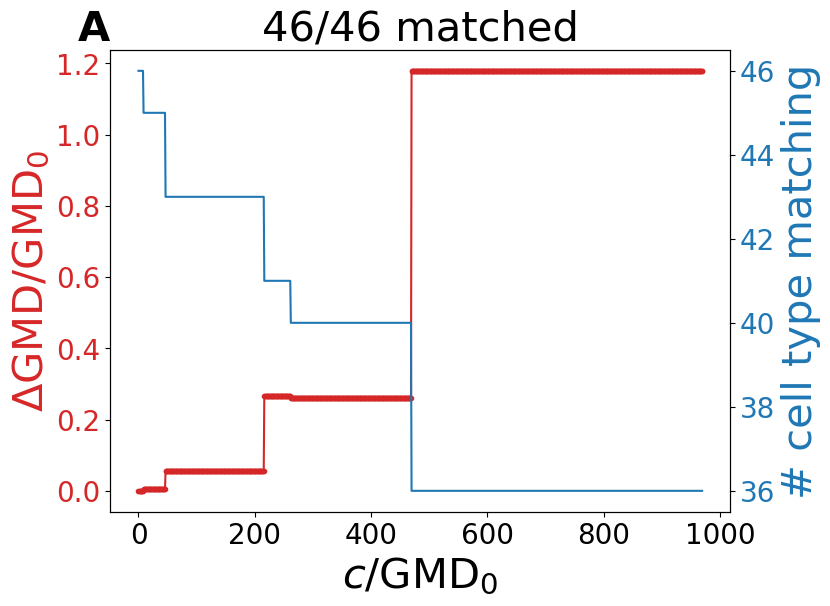

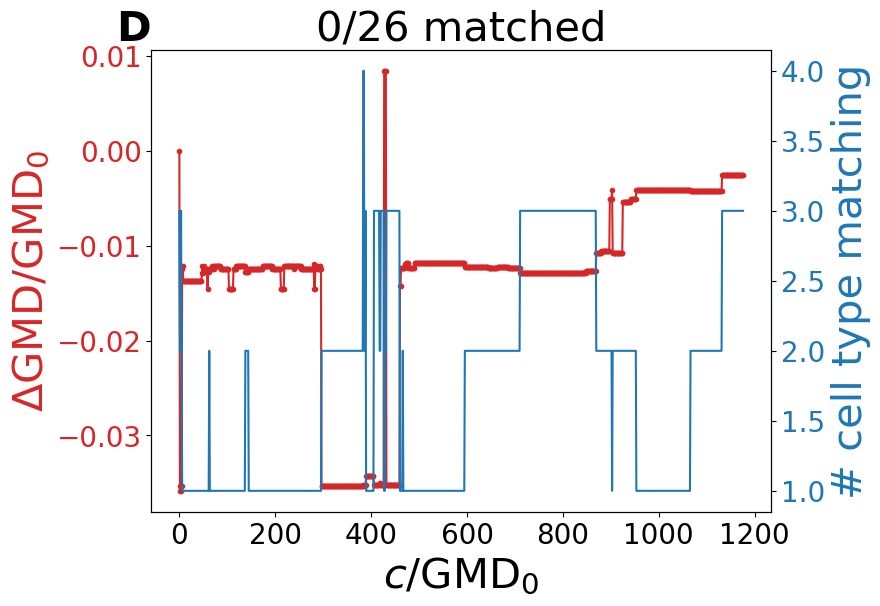

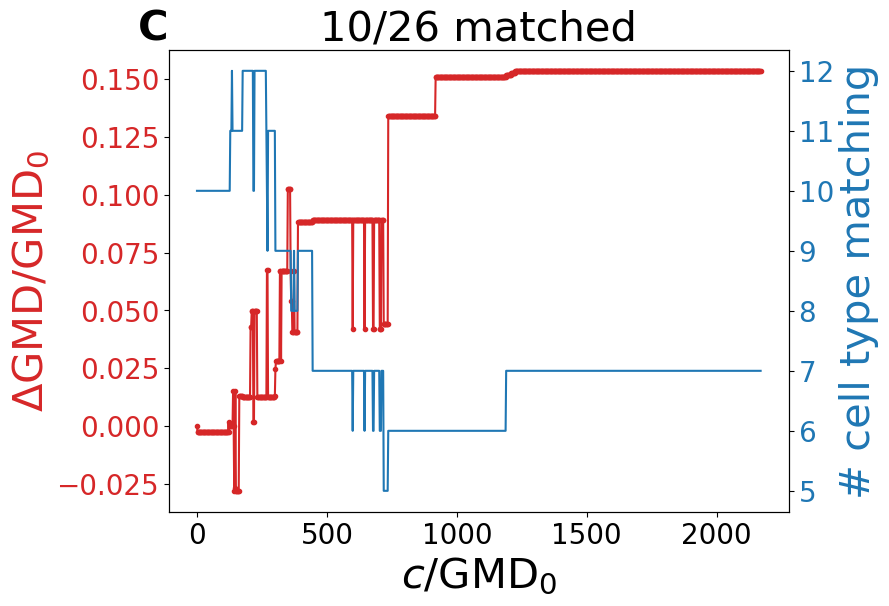

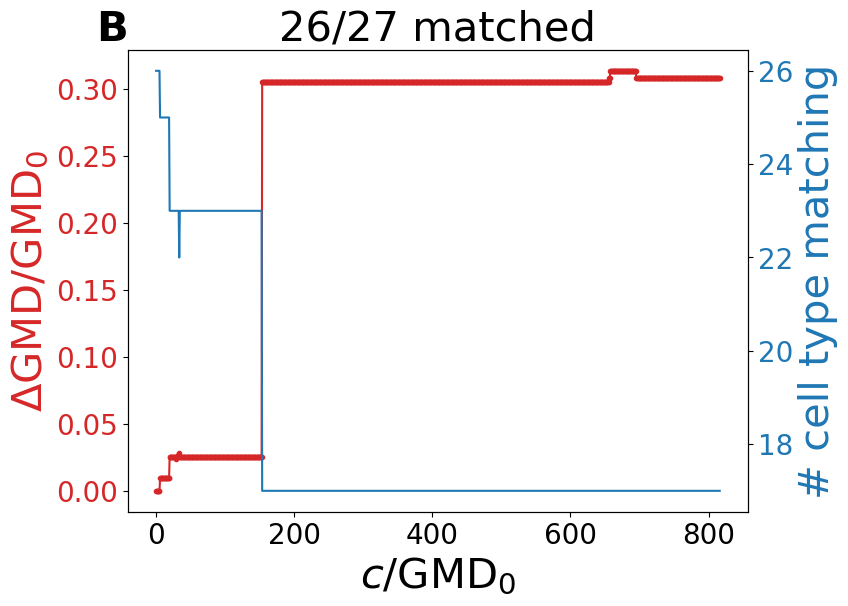

In [22]:
matchscorevals = to_analyse.nhood_ntype_match_score.values

labels = 'ADCB'

for ind, obj in enumerate(plot_objects):
    n_typematches, edistance, num_counts = obj
    fig, ax1 = plt.subplots(figsize=(8,6))
    color = 'tab:red'
    # ax1.set_xlabel(r'$-\delta$', size=30)
    ax1.set_xlabel(r'$c/\mathrm{GMD}_0$', size=30)
    label = labels[ind]
    ax1.text(-0.0, 1, label, transform=ax1.transAxes, fontsize=30, fontweight='bold', va='bottom',  ha='right')

    ids = pairs[ind]
    tit_string = f'{matchscorevals[ind]} matched' #{ids[0]}, {ids[1]}
    ax1.set_title(tit_string, fontsize=30)
    ax1.set_ylabel(r'$\Delta \mathrm{GMD}/\mathrm{GMD}_0$', color=color, size=30)
    norm_edistance = (np.array(edistance)- edistance[0])/edistance[0]
    norm_deltas = np.array(deltas)/edistance[0]

    ax1.plot(norm_deltas, norm_edistance, color=color, marker='.')
    ax1.tick_params(axis='y', labelcolor=color, labelsize=20)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('# cell type matching', color=color, size=30)  # we already handled the x-label with ax1
    ax2.plot(norm_deltas, n_typematches, color=color, marker='')
    ax2.tick_params(axis='y', labelcolor=color, labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)


    
    if save_things:
        plt.savefig(f'../figures/{nb_name}/stability_figure_{label}.pdf', transparent=True, dpi=300, bbox_inches='tight')
        plt.savefig(f'../figures/{nb_name}/stability_figure_{label}.png', transparent=True, dpi=300, bbox_inches='tight')

    plt.show()

    # plt.show()

In [23]:

# # for i in range(len(n_ids)):
#     # id_A = n_ids[i]
# id_A_ew_adj_mat = hemi_graphs[id_A]['ew_adj_mat']
# id_A_ew_nnames = hemi_graphs[id_A]['ew_g_nnames']

#     # for j in range(i+1, len(n_ids)):
#         # id_B = n_ids[j]
# id_B_ew_adj_mat = hemi_graphs[id_B]['ew_adj_mat']
# id_B_ew_nnames = hemi_graphs[id_B]['ew_g_nnames']



# gs = {id_A:id_A_ew_adj_mat, id_B:id_B_ew_adj_mat}
        
# srtd = sorted([(gs[k], k) for k in [id_A, id_B]], key=lambda x:x[0].shape[1])
# # adj_1 = srtd[0][0] # smaller graph
# # adj_2 = srtd[1][0] # larger graph
# id_1 = srtd[0][1]
# id_2 = srtd[1][1]

# id_1_ew_nnames = hemi_graphs[id_1]['ew_g_nnames']
# id_2_ew_nnames = hemi_graphs[id_2]['ew_g_nnames']

# one_index = np.arange(len(id_1_ew_nnames))[id_1 == np.array(id_1_ew_nnames)][0]
# two_index = np.arange(len(id_2_ew_nnames))[id_2 == np.array(id_2_ew_nnames)][0]
# pmatch = np.array([[one_index, two_index]])  # partial match seeding.


In [24]:

# m_output = []
# ctype_mapping_total = []
# # deltas = [0, 100, 300, 500, 700, 800, 1000, 1200, 1500,]
# deltas = np.arange(0, 1000000, 1000)
# # delta = 1500
# for delta in deltas:
#     delta_unit_mat = -delta * np.identity(len(id_B_ew_nnames))
#     delta_unit_mat[one_index, two_index] = 0 # don't penilise ego node matching
#     perm_inds, id_1, id_2 = perform_matching(id_A=id_1, id_B=id_2, graphs=gs, match_args={'rng':0, 'padding':'naive', 'transport':True, 'partial_match':pmatch, 'n_init':1, 'S':delta_unit_mat})
#     # print(perm_inds)

#     # all_inds = list(range(hemi_graphs[id_2]['ew_adj_mat'].shape[1]))
#     # not_matched = [int(i) for i in all_inds if i not in perm_inds]
#     # full_inds = np.concatenate([perm_inds, not_matched])

#     wadj_1 = hemi_graphs[id_1]['ew_adj_mat']# smaller weighted adj mat
#     wadj_2 = hemi_graphs[id_2]['ew_adj_mat']# larger weighted adj mat

#     all_inds = list(range(wadj_2.shape[1]))
#     not_matched = [int(i) for i in all_inds if i not in perm_inds]
#     full_inds = np.concatenate([perm_inds, not_matched])


#     calc = matching_distance(id_1=id_A, id_2=id_B, adj_1=wadj_1, adj_2=wadj_2, perm_inds=perm_inds, directed=True)
#     # calc.update({'id_1': id_A, 'id_2':id_B})
#     m_output.append(calc)



#     # order_1 = pd.DataFrame({'id_1':(id_1_ew_nnames)})
#     # order_2 = pd.DataFrame({'id_2':(id_2_ew_nnames)})
#     # mapping = get_mapping_df(structure_1=order_1, structure_2=order_2, colnames=['id_1_index', 'id_2_index'], full_inds=full_inds)[['id_1', 'id_2']]
#     # cols = ['bodyId', 'type', 'instance']
#     # col_names = ['id_1'] + [f'{col}_id_1' for col in cols[1:]] + ['id_2'] + [f'{col}_id_2' for col in cols[1:]]
#     # ctype_mapping = mapping.set_index('id_1').join(vnc_meta[cols].set_index('bodyId').add_suffix('_id_1')).reset_index().set_index('id_2').join(vnc_meta[cols].set_index('bodyId').add_suffix('_id_2')).reset_index()[col_names]
#     # ctype_mapping['delta'] = delta
#     # ctype_mapping_total.append(ctype_mapping)
#     id_1_ew_nnames_ego_removed = np.array(id_1_ew_nnames)[list(range(one_index)) + list(range(one_index+1,len(id_1_ew_nnames)))]
#     id_2_ew_nnames_ego_removed = np.array(id_2_ew_nnames)[list(range(two_index)) + list(range(two_index+1,len(id_2_ew_nnames)))]

#     two_index_removed_full_inds = full_inds[~(full_inds==two_index)]
#     full_inds_ego_removed = two_index_removed_full_inds - (two_index_removed_full_inds > two_index)
#     order_1 = pd.DataFrame({'id_1':(id_1_ew_nnames_ego_removed)})
#     order_2 = pd.DataFrame({'id_2':(id_2_ew_nnames_ego_removed)})

#     # order_1 = pd.DataFrame({'id_1':(id_1_ew_nnames)})
#     # order_2 = pd.DataFrame({'id_2':(id_2_ew_nnames)})
#     mapping = get_mapping_df(structure_1=order_1, structure_2=order_2, colnames=['id_1_index', 'id_2_index'], full_inds=full_inds_ego_removed)[['id_1', 'id_2']]
#     cols = ['bodyId', 'type', 'instance']
#     col_names = ['id_1'] + [f'{col}_id_1' for col in cols[1:]] + ['id_2'] + [f'{col}_id_2' for col in cols[1:]]
#     ctype_mapping = mapping.set_index('id_1').join(vnc_meta[cols].set_index('bodyId').add_suffix('_id_1')).reset_index().set_index('id_2').join(vnc_meta[cols].set_index('bodyId').add_suffix('_id_2')).reset_index()[col_names]
#     ctype_mapping['delta'] = delta
#     ctype_mapping_total.append(ctype_mapping)


In [25]:
# edistance = [d['euclidean_distance'] for d in m_output]

# joint_counter = Counter(ctype_mapping['type_id_2']) & Counter(ctype_mapping['type_id_1'])
# n_typematch = (sum(ctype_mapping['type_id_1'] == ctype_mapping['type_id_2']))

In [26]:
# one_cell_types = [key for key, val in dict(joint_counter).items() if val == 1]
# count_one_cell_types_1 = ctype_mapping[ctype_mapping.type_id_1.isin(one_cell_types)].value_counts('type_id_1').sort_index()
# count_one_cell_types_2 = ctype_mapping[ctype_mapping.type_id_2.isin(one_cell_types)].value_counts('type_id_2').sort_index()
# unique_one_cell_types = count_one_cell_types_1.index[count_one_cell_types_1 == count_one_cell_types_2].tolist()

# multi_cell_types = [key for key, val in dict(joint_counter).items() if val > 1]
# count_multi_cell_types_1 = ctype_mapping[ctype_mapping.type_id_1.isin(multi_cell_types)].value_counts('type_id_1').sort_index()
# count_multi_cell_types_2 = ctype_mapping[ctype_mapping.type_id_2.isin(multi_cell_types)].value_counts('type_id_2').sort_index()
# unique_multi_cell_types = count_multi_cell_types_1.index[count_multi_cell_types_1 == count_multi_cell_types_2].tolist()


In [27]:
# n_typematches = []
# for ctype_mapping in ctype_mapping_total:
#     joint_counter = Counter(ctype_mapping['type_id_2']) & Counter(ctype_mapping['type_id_1'])
#     n_typematch = (sum(ctype_mapping['type_id_1'] == ctype_mapping['type_id_2']))
#     n_typematches.append(n_typematch)


In [28]:
# fig, ax1 = plt.subplots(figsize=(8,6))
# color = 'tab:red'
# ax1.set_xlabel(r'$-\delta$', size=30)

# ax1.set_ylabel(r'$\Delta$ GMD', color=color, size=30)
# norm_edistance = (np.array(edistance)- edistance[0])/edistance[0]
# ax1.plot(deltas, norm_edistance, color=color, marker='.')
# ax1.tick_params(axis='y', labelcolor=color, labelsize=20)

# ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('# cell type matching', color=color, size=30)  # we already handled the x-label with ax1
# ax2.plot(deltas, n_typematches, color=color, marker='')
# ax2.tick_params(axis='y', labelcolor=color, labelsize=20)

# # fig.tight_layout()  # otherwise the right y-label is slightly clipped
# # axins = inset_axes(ax1, width=2.2, height=1.4, loc=4, borderpad=6)


# axins = inset_axes(ax1, width="70%", height='70%', loc=4, borderpad=0, 
#                    bbox_to_anchor=(.45, .4, .5, .4,),
#                    bbox_transform=ax1.transAxes)

# # ax1.add_patch(plt.Rectangle((.45, .4), .5, .4, ls="--", ec="c", fc="none",
# #                            transform=ax1.transAxes))
# num = (
#     "single",
#     "multi",
# )
# num_counts = {
#     "Unique": np.array([len(unique_one_cell_types), len(unique_multi_cell_types)]),
#     "Not unique": np.array([len(one_cell_types)-len(unique_one_cell_types), len(multi_cell_types)-len(unique_multi_cell_types)]),
# }
# width = 0.5

# # fig, ax = plt.subplots(figsize=(3,2))
# bottom = np.zeros(2)

# for boolean, num_count in num_counts.items():
#     p = axins.bar(num, num_count, width, label=boolean, bottom=bottom)
#     bottom += num_count

# # ax.set_title("Number of penguins with above average body mass")
# axins.legend(loc="upper right", fontsize=10)
# axins.tick_params(axis='both', which='major', labelsize=15)
# axins.tick_params(axis='both', which='minor', labelsize=8)
# axins.set_yticks(bottom)
# # plt.xlim([0,100000])
# plt.show()

# # plt.show()

In [29]:
# print('number of changes in cell type matched number')
# sum(abs(np.array(n_typematches)[1:] - np.array(n_typematches)[:-1])>0.)

In [30]:
# print('number of changes in GMD value')
# sum(abs(norm_edistance[1:] - norm_edistance[:-1])>0.)

In [31]:
# sum(abs(norm_edistance[1:] - norm_edistance[:-1])>0.)/len(norm_edistance)

In [32]:

# num = (
#     "single",
#     "multi",
# )
# num_counts = {
#     "Unique": np.array([len(unique_one_cell_types), len(unique_multi_cell_types)]),
#     "Not unique": np.array([len(one_cell_types)-len(unique_one_cell_types), len(multi_cell_types)-len(unique_multi_cell_types)]),
# }
# width = 0.5

# fig, ax = plt.subplots(figsize=(3,2))
# bottom = np.zeros(2)

# for boolean, num_count in num_counts.items():
#     p = ax.bar(num, num_count, width, label=boolean, bottom=bottom)
#     bottom += num_count

# # for c in ax.containers:
# #     ax.bar_label(c)

# # ax.set_title("Number of penguins with above average body mass")
# ax.legend(loc="upper right")
# ax.tick_params(axis='both', which='major', labelsize=20)
# ax.tick_params(axis='both', which='minor', labelsize=8)
# # ax.set_yticks([int(i) for i in np.linspace(0, max(bottom), 3)])
# ax.set_yticks(bottom)

# plt.show()